In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow import keras

In [3]:
images = tfds.load(name='colorectal_histology',split='train',as_supervised=True)
images = images.batch(8)
images = images.map(lambda img,lab: (tf.image.convert_image_dtype(img, dtype=tf.float32),lab))
images = images.map(lambda img, lab: (img,img))

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteOCCEFP/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


# Arguments

In [39]:
LATENT_DIM = 100
LR = 1e-3
EPOCHS = 30

# Autoencoder

In [65]:
encoder = keras.Sequential(
    [
    keras.layers.Input(shape=(150, 150, 3)),
    keras.layers.experimental.preprocessing.Resizing(128, 128),
    keras.layers.Conv2D(filters=32,
                        kernel_size=(4,4),
                        strides=(4,4),
                        activation='relu',
                        padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2,2),
                        strides=(1,1),
                        padding = 'same'),
    keras.layers.Conv2D(filters=64,
                        kernel_size=(2,2),
                        strides=(2,2),
                        activation='relu',
                        padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2,2),
                        strides=(1,1),
                        padding = 'same'), 
    keras.layers.Conv2D(filters=128,
                        kernel_size=(2,2),
                        strides=(2,2),
                        activation='relu',
                        padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2,2),
                        strides=(1,1),
                        padding = 'same'),
    keras.layers.Flatten(),
    keras.layers.Dense(LATENT_DIM)
    ]
)

encoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_11 (Resizing)       (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        1568      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         32896     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 128)       

In [66]:
decoder = keras.Sequential(
    [
     keras.layers.Input(shape=(LATENT_DIM)),
     keras.layers.Dense(4 * 4 * 128),
     keras.layers.Reshape((4, 4, 128)),
     keras.layers.Conv2DTranspose(filters=128,
                        kernel_size=(4,4),
                        strides=(4,4),
                        padding='same'),   
     keras.layers.ReLU(),
     keras.layers.Conv2DTranspose(filters=64,
                        kernel_size=(2,2),
                        strides=(2,2),
                        padding='same'),
     keras.layers.ReLU(),
     keras.layers.Conv2DTranspose(filters=32,
                        kernel_size=(4,4),
                        strides=(4,4),
                        padding='same'),
     keras.layers.ReLU(),
     keras.layers.Conv2DTranspose(filters=3,
                        kernel_size=(1,1),
                        strides=(1,1),
                        padding='same',
                        activation='sigmoid'),
     tf.keras.layers.experimental.preprocessing.Resizing(150, 150)
    ]
  )

decoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 16, 16, 128)       262272    
_________________________________________________________________
re_lu_15 (ReLU)              (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 32, 32, 64)        32832     
_________________________________________________________________
re_lu_16 (ReLU)              (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 128, 128, 32)    

In [32]:
class Autoencoder(keras.Model):
  
  def __init__(self, encoder, decoder):
    super(Autoencoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def compile(self, optim, loss):
    super(Autoencoder, self).compile()
    self.optim = optim
    self.loss_fn = loss

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  def train_step(self, data):
    x, y = data[0], data[1]

    with tf.GradientTape() as tape:
      decoded = self(x)
      loss = self.loss_fn(y, decoded)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optim.apply_gradients(zip(gradients, self.trainable_variables))

    return {'Loss': loss}

In [26]:
def schedule(epoch, lr):
  epochs = [27]
  if epoch in epochs:
    lr = lr*0.1
    print(f'Learning rate: {lr}')
    return lr
  
  return lr

In [ ]:
optimizer = keras.optimizers.Adam(LR)

model = Autoencoder(keras.models.clone_model(encoder),
                    keras.models.clone_model(decoder))
model.compile(optimizer, keras.losses.MeanSquaredError())
model.fit(images, epochs = EPOCHS,
          callbacks=[keras.callbacks.LearningRateScheduler(schedule)])

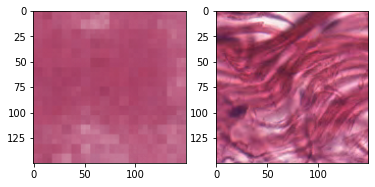

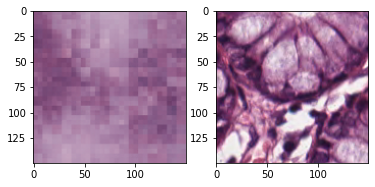

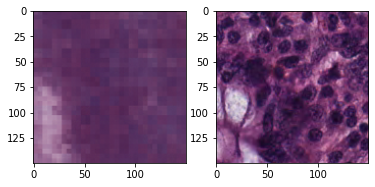

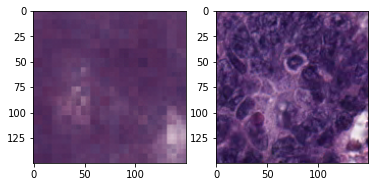

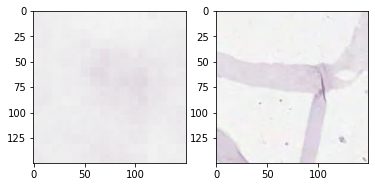

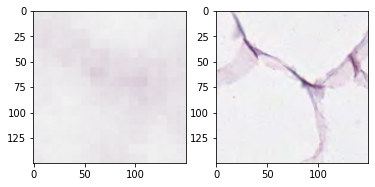

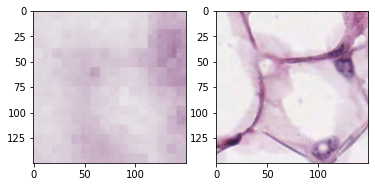

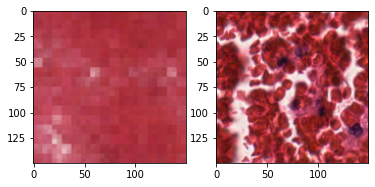

In [36]:
decoded_test = model.predict(images.take(1))

for batch in images.take(1):
  for img, ground_truth in zip(decoded_test, batch[0]):
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    f.add_subplot(1, 2, 2)
    plt.imshow(ground_truth)
    plt.show(block=True)

# Autoencoder with Perceptual Loss

In [63]:
class AutoencoderPercLoss(keras.Model):
  
  def __init__(self, encoder, decoder, features_extractor, alpha=0.1):
    super(AutoencoderPercLoss, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.features_extractor = features_extractor
    self.alpha = alpha

    self.resizing_layer = tf.keras.Sequential(
        [
         tf.keras.layers.Input(shape=(150, 150, 3)),
         tf.keras.layers.experimental.preprocessing.Resizing(224, 224)
        ]
    )


  def compile(self, optim, loss):
    super(AutoencoderPercLoss, self).compile()
    self.optim = optim
    self.loss_fn = loss


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


  def train_step(self, data):
    x, y = data[0], data[1]

    with tf.GradientTape() as tape:
      decoded = self(x)

      # Resize and normalize in range [0, 255] the features
      y_resized = self.resizing_layer(y)*255
      dec_resized = self.resizing_layer(decoded)*255

      # Preprocess images such that they can be feed to vgg16
      y_for_vgg = tf.keras.applications.vgg16.preprocess_input(y_resized)
      dec_for_vgg= tf.keras.applications.vgg16.preprocess_input(dec_resized)

      # Extract features
      y_features = self.features_extractor(y_for_vgg)
      dec_features = self.features_extractor(dec_for_vgg)

      loss = self.loss_fn(y, decoded)*(1-self.alpha) +\
       self.alpha*self.loss_fn(y_features, dec_features)


    gradients = tape.gradient(loss, self.trainable_variables)
    self.optim.apply_gradients(zip(gradients, self.trainable_variables))

    return {'Loss': loss}

In [57]:
pretrained_vgg16 = tf.keras.applications.VGG16()

# remove the output layer
feature_extractor = tf.keras.Model(inputs=pretrained_vgg16.inputs, outputs=pretrained_vgg16.layers[-2].output)
feature_extractor.trainable = False

In [ ]:
autoencoder = AutoencoderPercLoss(keras.models.clone_model(encoder),
                                  keras.models.clone_model(decoder),
                                  feature_extractor)
autoencoder.compile(keras.optimizers.Adam(LR),
                    keras.losses.MeanSquaredError())
history = autoencoder.fit(images, epochs=30)

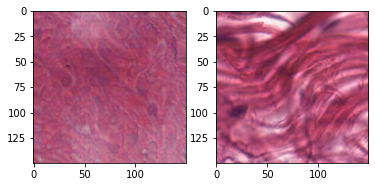

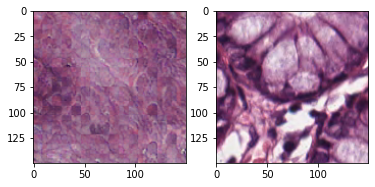

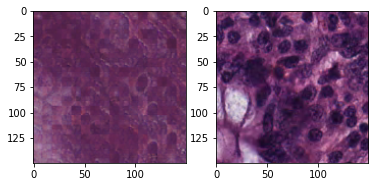

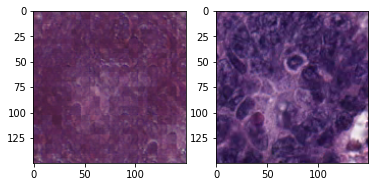

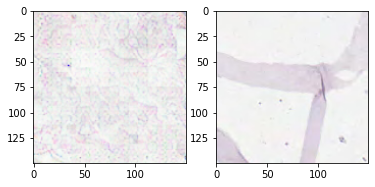

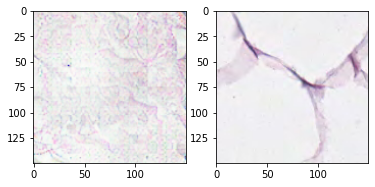

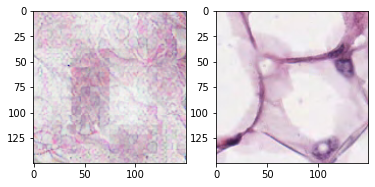

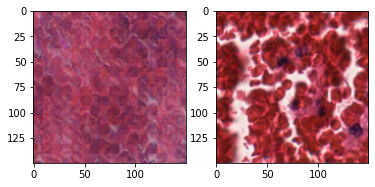

In [70]:
decoded_test = autoencoder.predict(images.take(1))

for batch in images.take(1):
  for img, ground_truth in zip(decoded_test, batch[0]):
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    f.add_subplot(1, 2, 2)
    plt.imshow(ground_truth)
    plt.show(block=True)

# VAE

In [76]:
class Sampling(keras.layers.Layer):

  def call(self, inputs):
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    latent_dim = tf.shape(mu)[1]
    eps = tf.keras.backend.random_normal((batch, latent_dim))
    return mu + tf.exp(0.5*sigma)*eps

In [77]:
inputs = keras.layers.Input(shape=(150, 150, 3))
x = keras.layers.experimental.preprocessing.Resizing(128, 128)(inputs)
x = keras.layers.Conv2D(filters=32,
                        kernel_size=(4,4),
                        strides=(4,4),
                        activation='relu',
                        padding='same')(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2),
                        strides=(1,1),
                        padding = 'same')(x)
x = keras.layers.Conv2D(filters=64,
                        kernel_size=(2,2),
                        strides=(2,2),
                        activation='relu',
                        padding='same')(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2),
                        strides=(1,1),
                        padding = 'same')(x)
x = keras.layers.Conv2D(filters=128,
                        kernel_size=(2,2),
                        strides=(2,2),
                        activation='relu',
                        padding='same')(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2),
                        strides=(1,1),
                        padding = 'same')(x)
x = keras.layers.Flatten()(x)
mu = keras.layers.Dense(LATENT_DIM)(x)
sigma = keras.layers.Dense(LATENT_DIM)(x)
z = Sampling()([mu, sigma])

vae_encoder = keras.Model(inputs, [mu, sigma, z])


vae_encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
resizing_18 (Resizing)          (None, 128, 128, 3)  0           input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 32)   1568        resizing_18[0][0]                
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 32, 32, 32)   0           conv2d_18[0][0]                  
____________________________________________________________________________________________

In [102]:
class VAE(keras.Model):
  
  def __init__(self, encoder, decoder):
    super(VAE, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.beta = 2

  def compile(self, optim, loss):
    super(VAE, self).compile()
    self.optim = optim
    self.reconstruction_loss = loss

  def call(self, x):
    mu, sigma, z = self.encoder(x)
    decoded = self.decoder(z)
    return mu, sigma, decoded

  def train_step(self, data):
    x, y = data[0], data[1]

    with tf.GradientTape() as tape:
      mu, sigma, decoded = self(x)
      kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, decoded), axis=(1, 2)
                )
            )
      
      loss = reconstruction_loss + self.beta*kl_loss # sum over components, mean over batch

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optim.apply_gradients(zip(gradients, self.trainable_variables))

    return {'Loss': loss, 'KL Loss': kl_loss, 'Reconstruction loss': reconstruction_loss}

In [103]:
optimizer = keras.optimizers.Adam(LR)

vae = VAE(keras.models.clone_model(vae_encoder),
                    keras.models.clone_model(decoder))
vae.compile(optimizer, keras.losses.MeanSquaredError())
vae.fit(images, epochs = EPOCHS)

Epoch 1/30
625/625 [==============================] - 8s 11ms/step - Loss: 12763.3659 - KL Loss: 24.5652 - Reconstruction loss: 12714.2356
Epoch 2/30
625/625 [==============================] - 7s 11ms/step - Loss: 12234.3407 - KL Loss: 33.6471 - Reconstruction loss: 12167.0465
Epoch 3/30
625/625 [==============================] - 7s 11ms/step - Loss: 12093.4687 - KL Loss: 36.2110 - Reconstruction loss: 12021.0466
Epoch 4/30
625/625 [==============================] - 7s 11ms/step - Loss: 12025.7626 - KL Loss: 36.9247 - Reconstruction loss: 11951.9131
Epoch 5/30
625/625 [==============================] - 7s 11ms/step - Loss: 11995.8000 - KL Loss: 37.8284 - Reconstruction loss: 11920.1432
Epoch 6/30
625/625 [==============================] - 7s 11ms/step - Loss: 11970.6062 - KL Loss: 38.3748 - Reconstruction loss: 11893.8566
Epoch 7/30
625/625 [==============================] - 7s 11ms/step - Loss: 11945.7775 - KL Loss: 40.1649 - Reconstruction loss: 11865.4477
Epoch 8/30
625/625 [=======

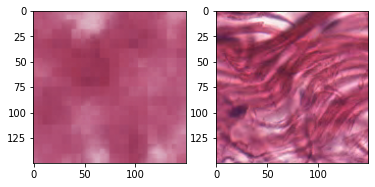

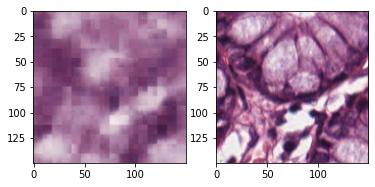

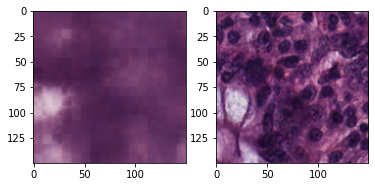

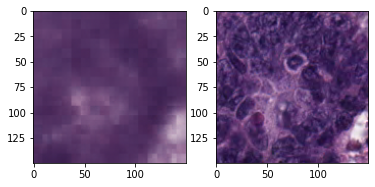

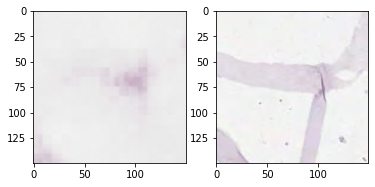

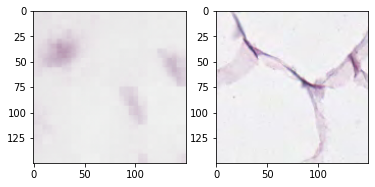

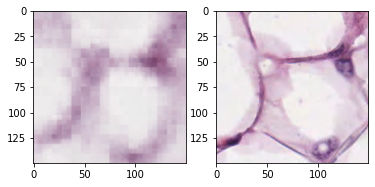

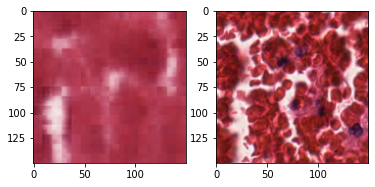

In [104]:
_, _, decoded_test = vae.predict(images.take(1))

for batch in images.take(1):
  for img, ground_truth in zip(decoded_test, batch[0]):
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    f.add_subplot(1, 2, 2)
    plt.imshow(ground_truth)
    plt.show(block=True)